In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

### Dataset import

In [107]:
elliptical = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\elliptical.txt",delimiter=' ',names = ['x','y'])
square = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\square.txt",delimiter=' ',names = ['x','y'])

### Simulation Dataset

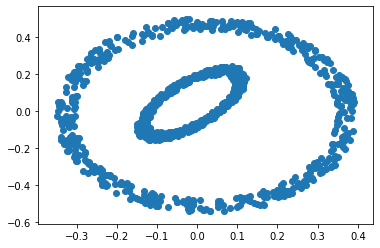

In [28]:
# plt.scatter(square.loc[:,"x"],square.loc[:,"y"])
plt.scatter(elliptical.loc[:,"x"],elliptical.loc[:,"y"])

In [29]:
np_square = np.array(square)
np_elliptical = np.array(elliptical)

#### Build Kmeans

In [30]:
def distance(a,b):
    """
    Return euclidean distance between np.arrays a and b
    """
    return np.sqrt(sum(np.square(a-b)))

def initiate_centroids(k,data,init_random):
    """
    Given k clusters and the data set,
    Return the initial k centroids
    """
    centroids = []
    for i in range(k):
        if init_random == True:
            centroids.append(data[np.random.randint(0,len(data))]) #Randomly pick centroid index
        else:
            centroids.append(data[i])
    return np.asarray(centroids)

def cluster_assignment(data,centroids):
    """
    Assign data to k clusters, given centroids
    """
    cluster = np.zeros(len(data))
    for point in range(len(data)):
        distances =[distance(data[point],centroid) for centroid in centroids] # computing distance from each point in dataset to each centroid
        # print(distances)
        index = np.argmin(distances) #assigning each point to closest centroid
        cluster[point] = index
    return cluster

def compute_centroids(k, data, cluster):
    """
    Compute new centroids
    """
    new_centroids = []
    for i in range(k):
        node = []
        for j in range(len(data)):
            if cluster[j]==i:
                node.append(data[j])
        new_centroids.append(np.mean(node, axis=0))
    return np.array(new_centroids,dtype=object)

def measure_change(centroids_current,new_centroids):
    """
    Calculate the distance between previous centroids and current
    """
    delta = 0
    for a,b in zip(centroids_current,new_centroids):
        delta+=distance(a,b)
    return delta

In [31]:
def kmeans_clustering(data,tol,k,init_random):
    np.random.seed(100)
    """
    Kmeans clustering algorithm
    Input is numpy array, tolerence, max_iterations, k # of cluster, and centroid init_type 
    ---------
    Returns list of assigned cluster for each element
    """
    centroids_current = initiate_centroids(k,data,init_random)
    change = 50
    while change > tol: #stopping condition
        cluster = cluster_assignment(data,centroids_current) #assign clusters using centroids_current
        new_centroids = compute_centroids(k, data, cluster) # calcualte new centroids with the latest assignemnts
        change = measure_change(centroids_current,new_centroids) # calculate the distance between previous centroids using eulcidean distance function
        centroids_current = new_centroids #assign new centroids as the 'current' ones and check stopping condition at the top
    return cluster

#### Fit Kmeans to Both Datasets and Graph

In [32]:
result_square_kmeans = kmeans_clustering(np_square,tol=.001,k=2,init_random = True)
result_elliptical_kmeans = kmeans_clustering(np_elliptical,tol=.001,k=2,init_random =True)


Text(0.5, 1.0, 'Scatter Plot of Square Data w/ \n Color Coded by Cluster (KMeans)')

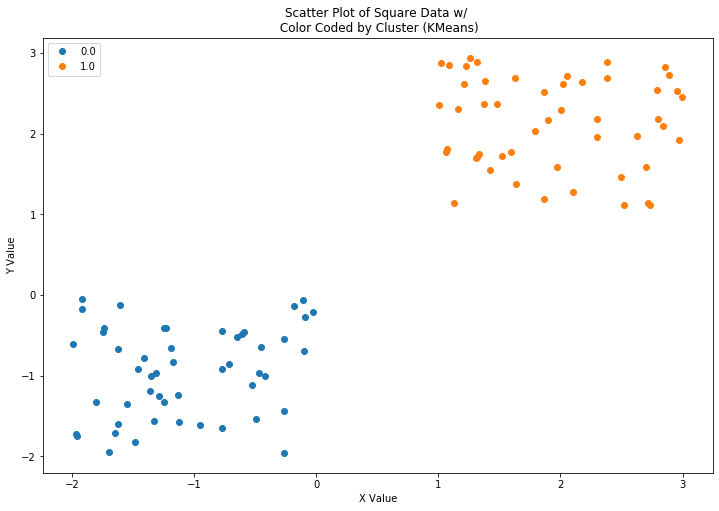

In [33]:
square['kmeans_cluster'] = result_square_kmeans
clustered_data = square.groupby("kmeans_cluster")
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
for name, group in clustered_data:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('X Value')
ax.set_ylabel('Y Value')
ax.set_title('Scatter Plot of Square Data w/ \n Color Coded by Cluster (KMeans)')

Text(0.5, 1.0, 'Scatter Plot of Elliptical Data w/ \n Color Coded by Cluster (KMeans)')

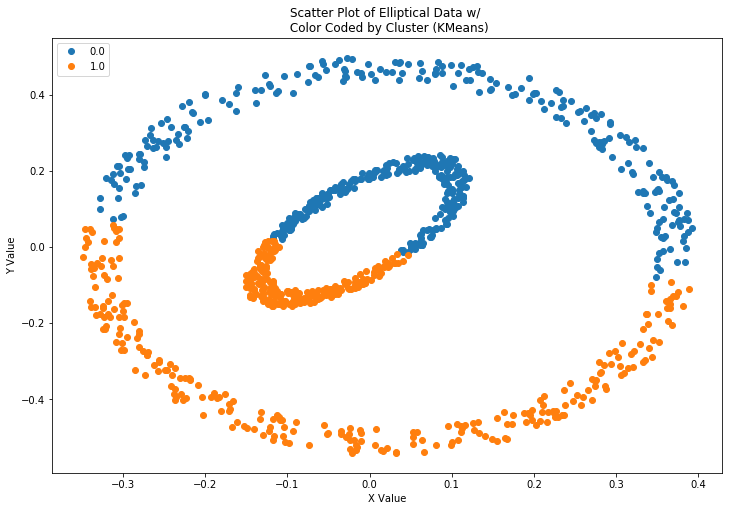

In [34]:
elliptical['kmeans_cluster'] = result_elliptical_kmeans
clustered_data = elliptical.groupby("kmeans_cluster")
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
for name, group in clustered_data:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('X Value')
ax.set_ylabel('Y Value')
ax.set_title('Scatter Plot of Elliptical Data w/ \n Color Coded by Cluster (KMeans)')

#### Build Spectral Clustering

Give dataset, let the similarity matrix $S_{ij}$ be the similarity between data point $i,j$. Let the Diagonal matrix $D= \sum_j S_{ij}$.

We define the **unnormalized** Laplacian matrix $L= S-D$

We define the **normalized** Laplacian matrix $L = D^{-\frac{1}{2}}LD^{-\frac{1}{2}}$

Then calculate eigenvalues and vectors of $L$, then use kmeans to cluster that result

In [227]:
def similarity_calc(data,type,sigma,epsilon):
    type = type.lower()
    """
    Given two np array, the type of similarity calculation, and threshold similarity epsilon
    ---------
    Return the appropriate Similarity Matrix
    """
    sim_matrix = np.zeros((len(data),len(data)))
    for i in range(len(data)):
        for j in range(len(data)):
            if type == 'cosine':
                sim_matrix[i,j] = np.dot(data[i],data[j])/(np.linalg.norm(data[i])*(np.linalg.norm(data[j])))
            elif type == 'gaussian':
                sim_matrix[i,j] = np.exp(-distance(data[i],data[j])**2/(2*sigma**2))
            else:
                print("please choose 'gaussian' or 'cosine'")
                break
    return np.where(sim_matrix < epsilon,0,sim_matrix)

def degree_matrix(sim_matrix):
    """"
    Given a similarity matrix
    --------
    Returns the degree matrix
    """
    d_matrix = np.zeros((len(sim_matrix),len(sim_matrix)))
    for i in range(len(sim_matrix)):
        d_matrix[i,i] = sum(sim_matrix[i])    
    return d_matrix

In [59]:
def spectral_clustering(data,k,tol,normalization,similarity,init_random,sigma,epsilon):
    """
    Spectral clustering algorithm
    Input is numpy array, tolerence,type of normalization and similarity, and k # of cluster
    ---------
    Cluster initiation is random
    ---------
    Returns list of assigned cluster for each element
    """
    s_matrix = similarity_calc(data,similarity,sigma,epsilon)
    d_matrix = degree_matrix(s_matrix)
    l = d_matrix - s_matrix
    if normalization == True:
        # d_matrix_frac = fractional_matrix_power(d_matrix, -0.5)
        # l = (d_matrix_frac) * l * (d_matrix_frac)
        l = np.linalg.inv(d_matrix) *l
    else: 
        pass
    eig_val,eig_vec = np.linalg.eig(l)
    eig_val_non_zero = eig_val[np.where(eig_val>0)]
    k_small_eigval_nonzero = np.sort(eig_val_non_zero)[:k] #sort the list and get the first k elements
    k_small_eigval_nonzero_idx =[]
    for i in range(len(k_small_eigval_nonzero)):
        k_small_eigval_nonzero_idx.append(np.where((eig_val == k_small_eigval_nonzero[i]))) #find the idx of where these elements are in the eig_val matrix
    data = eig_vec[:,k_small_eigval_nonzero_idx] #pull out the the two idx corresponding to smallest non-zero eig_val
    data= data.reshape(data.shape[0],data.shape[1])
    cluster = kmeans_clustering(data,tol,k,init_random=True)
    return cluster

#### Fit Spectral to Both Datasets and Graph

Text(0.5, 1.0, 'Scatter Plot of Square Data w/ \n Color Coded by Cluster (Spectral) w/Gaussian Measure')

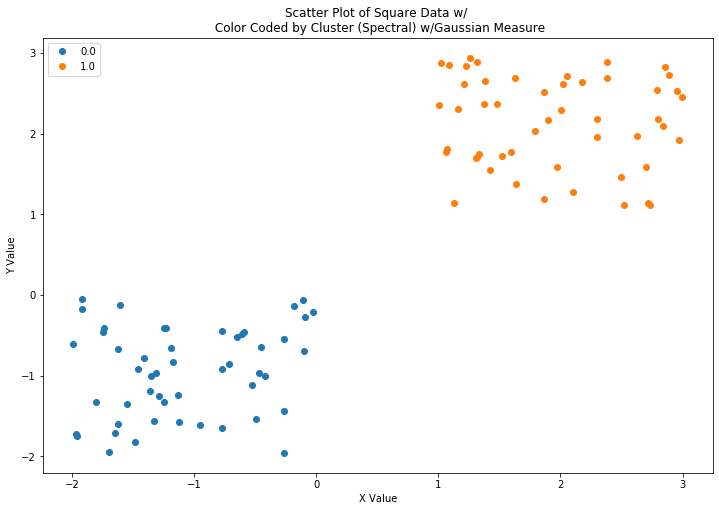

In [97]:
result_square_spectral = spectral_clustering(np_square,sigma = 2,tol=.001,k=2,normalization = False,similarity= 'gaussian',init_random = True,epsilon=.3)
square['spectral_cluster'] = result_square_spectral
clustered_data = square.groupby("spectral_cluster")
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
for name, group in clustered_data:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend(numpoints=1, loc='upper left')
ax.set_xlabel('X Value')
ax.set_ylabel('Y Value')
ax.set_title('Scatter Plot of Square Data w/ \n Color Coded by Cluster (Spectral) w/Gaussian Measure')

Text(0.5, 1.0, 'Scatter Plot of Elliptical Data w/ \n Color Coded by Cluster (Spectral)')

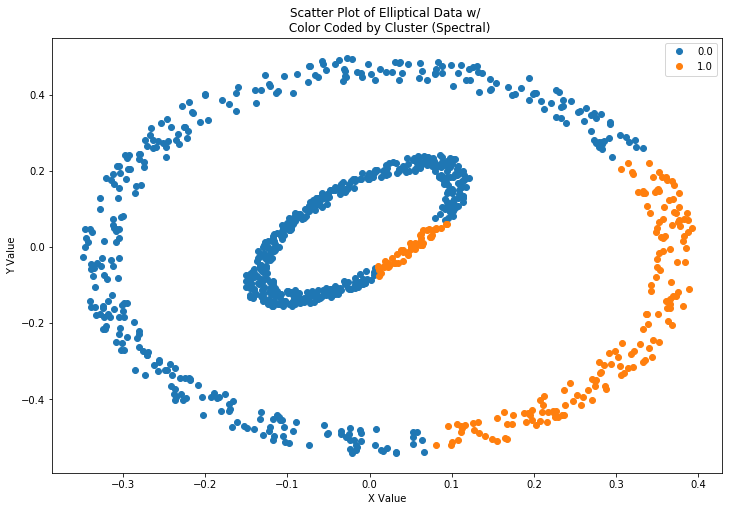

In [96]:
result_elliptical_spectral = spectral_clustering(np_elliptical,sigma = 2,tol=.001,k=2,
                            normalization = False,similarity= 'cosine',init_random = False,epsilon=.6)

elliptical['spectral_cluster'] = result_elliptical_spectral
clustered_data = elliptical.groupby("spectral_cluster")
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
for name, group in clustered_data:
    ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
ax.legend(numpoints=1, loc='upper right')
ax.set_xlabel('X Value')
ax.set_ylabel('Y Value')
ax.set_title('Scatter Plot of Elliptical Data w/ \n Color Coded by Cluster (Spectral)')

### Real-World Dataset

In [105]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [109]:
cho = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\cho.txt",delimiter='\t',header=None)
iyer = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\iyer.txt",delimiter='\t',header=None)

In [110]:
#### Rename cho and iyer columns
real_set_cols = cho.columns.tolist()
real_set_cols[0] = "gene_id"
real_set_cols[1] = "ground_truth"
cho.columns = real_set_cols
cho.set_index('gene_id',inplace=True)

real_set_cols = iyer.columns.tolist()
real_set_cols[0] = "gene_id"
real_set_cols[1] = "ground_truth"
iyer.columns = real_set_cols
iyer.set_index('gene_id',inplace=True)

In [213]:
"""Number of true clusters for each dataset"""
actual_k_cho = cho.ground_truth.unique().shape[0]
actual_k_iyer = iyer.ground_truth.unique().shape[0]
print(f'# Clusters Cho: {actual_k_cho} \n# Clusters iyer: {actual_k_iyer}')

# Clusters Cho: 5 
# Clusters iyer: 11


#### Fit KMeans to Cho and Iyer

##### Preprocessing

In [112]:
iyer.ground_truth.unique()
iyer_no_outliers = iyer[iyer['ground_truth']!=-1]

"""Scaling"""
sc = StandardScaler()
cho_sc_values = sc.fit_transform(cho.iloc[:,1:])
iyer_sc_values = sc.fit_transform(iyer.iloc[:,1:])

In [231]:
kmeans_iyer = kmeans_clustering(iyer_sc_values,.001,actual_k_iyer,init_random = True)
kmeans_cho = kmeans_clustering(cho_sc_values,.001,actual_k_cho,init_random= True)

#### Fit Spectral to Cho and Iyer

##### Preprocessing

In [219]:
iyer.ground_truth.unique()
iyer_no_outliers = iyer[iyer['ground_truth']!=-1]

"""Scaling"""
sc = StandardScaler()
cho_sc_values = sc.fit_transform(cho.iloc[:,1:])
iyer_sc_values = sc.fit_transform(iyer_no_outliers.iloc[:,1:])


In [230]:
spectral_iyer = spectral_clustering(iyer_sc_values, k=actual_k_iyer, tol=.001, normalization=False, similarity='cosine', init_random=True, sigma = 2,epsilon =.1)
spectral_cho = spectral_clustering(cho_sc_values, k=actual_k_cho, tol=.001, normalization=False, similarity='gaussian', init_random=True,sigma = 2,epsilon =.3)

### Classification Report: KMeans

In [232]:
print('\t'*2 +'Iyer KMeans Classifcation Report \n'+ f'{classification_report(iyer_no_outliers.ground_truth,(kmeans_iyer),zero_division=1)}')
print('\t'*2 +'Cho KMeans Classifcation Report \n'+ f'{classification_report(cho.ground_truth,kmeans_cho,zero_division=1)}')

		Iyer KMeans Classifcation Report 
              precision    recall  f1-score   support

         0.0       0.00      1.00      0.00         0
         1.0       0.00      0.00      0.00       100
         2.0       0.00      0.00      0.00       145
         3.0       0.00      0.00      0.00        34
         4.0       0.00      0.00      0.00        43
         5.0       0.00      0.00      0.00         7
         6.0       0.00      0.00      0.00        34
         7.0       0.11      0.07      0.09        14
         8.0       0.14      0.11      0.12        63
         9.0       0.17      0.05      0.08        19
        10.0       0.18      0.12      0.14        25

    accuracy                           0.02       484
   macro avg       0.05      0.12      0.04       484
weighted avg       0.04      0.02      0.03       484

		Cho KMeans Classifcation Report 
              precision    recall  f1-score   support

         0.0       0.00      1.00      0.00         0
       

### Classification Report: Spectral

In [214]:
print('\t'*2 +'Iyer Spectral Classifcation Report \n'+ f'{classification_report(iyer_no_outliers.ground_truth,spectral_iyer)}')
print('\t'*2 +'Cho Spectral Classifcation Report \n'+ f'{classification_report(cho.ground_truth,spectral_cho)}')

		Iyer Spectral Classifcation Report 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00       100
         2.0       0.00      0.00      0.00       145
         3.0       0.00      0.00      0.00        34
         4.0       0.00      0.00      0.00        43
         5.0       0.00      0.00      0.00         7
         6.0       0.23      0.26      0.25        34
         7.0       0.20      0.64      0.31        14
         8.0       0.00      0.00      0.00        63
         9.0       0.00      0.00      0.00        19
        10.0       0.00      0.00      0.00        25

    accuracy                           0.04       484
   macro avg       0.04      0.08      0.05       484
weighted avg       0.02      0.04      0.03       484

		Cho Spectral Classifcation Report 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
   